# Import all required libraries

In [1]:
!pip install split-folders
!pip install pydub
!pip install pesq
!pip install pystoi
!pip install git+https://github.com/aliutkus/speechmetrics#egg=speechmetrics[cpu]

  Cloning https://github.com/aliutkus/speechmetrics to /tmp/pip-install-u_x5luij/speechmetrics_d8b7c616df5b4ead9fba30e9f35f70f4
  Running command git clone -q https://github.com/aliutkus/speechmetrics /tmp/pip-install-u_x5luij/speechmetrics_d8b7c616df5b4ead9fba30e9f35f70f4
  Cloning https://github.com/vBaiCai/python-pesq to /tmp/pip-install-u_x5luij/pypesq_d3ec010519e84be5bd2e03ac45a09eb6
  Running command git clone -q https://github.com/vBaiCai/python-pesq /tmp/pip-install-u_x5luij/pypesq_d3ec010519e84be5bd2e03ac45a09eb6
  Cloning https://github.com/jfsantos/SRMRpy to /tmp/pip-install-u_x5luij/srmrpy_e566688618a54b71955d84115c2feb64
  Running command git clone -q https://github.com/jfsantos/SRMRpy /tmp/pip-install-u_x5luij/srmrpy_e566688618a54b71955d84115c2feb64
  Cloning https://github.com/ludlows/python-pesq to /tmp/pip-install-u_x5luij/pesq_40f40a3008f8477b9bc6042c1ba0e4df
  Running command git clone -q https://github.com/ludlows/python-pesq /tmp/pip-install-u_x5luij/pesq_40f40a300

In [3]:
############################################################ import libraries
import numpy as np
# Packages we're using
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
from tqdm import tqdm
import numpy as np
import math
from PIL import Image
import time
from pydub import AudioSegment
from pydub.playback import play
import glob
import os
from keras.callbacks import EarlyStopping
import tensorflow as tf
import splitfolders
import shutil
import random
# importing necessary libraries
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import Flatten,concatenate,UpSampling2D,ZeroPadding2D,Cropping2D
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.metrics import TopKCategoricalAccuracy
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM,Embedding,Rescaling,TimeDistributed,BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint
import wave
from pesq import pesq
import IPython.display as ipd
import librosa
import librosa.display
from ipykernel import kernelapp as app
import soundfile as sf
from pystoi import stoi
import speechmetrics
import sys

import numpy as np
# Packages we're using
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
from tqdm import tqdm
import numpy as np
import math
from PIL import Image
import time
from pydub import AudioSegment
from pydub.playback import play
import glob
import os
import tensorflow as tf
import splitfolders
import shutil
import keras
# importing necessary libraries
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import Flatten,concatenate,UpSampling2D,ZeroPadding2D,Cropping2D, Activation
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv1D, Conv1DTranspose
#from SpectralNormalizationKeras import DenseSN, ConvSN1D, ConvSN2D, ConvSN3D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.metrics import TopKCategoricalAccuracy
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM,Embedding,Rescaling,TimeDistributed,BatchNormalization
from keras.callbacks import ModelCheckpoint
import wave

# Obtain data from Kaggle and from our generated dataset

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
################################################################## Libri dataset
!kaggle datasets download -d earth16/libri-speech-noise-dataset

100% 6.03G/6.03G [00:58<00:00, 144MB/s]
100% 6.03G/6.03G [00:58<00:00, 110MB/s]


In [ ]:
################################################################# Unzip Libri dataset
!unzip /content/libri-speech-noise-dataset.zip

In [ ]:
################################################################### Unzip generated clean dataset
!unzip /content/drive/MyDrive/Clean_arr.zip -d /content/clean_data

In [ ]:
################################################################# Unzip generated noisy dataset
!unzip /content/drive/MyDrive/Noisy_arr.zip -d /content/noisy_data

#Listening to clean and noisy samples

In [ ]:
################################################################# Functions to obtain signal from spectogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0

rate = 16000

def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, 
                        magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, 
                       phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
   # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
     
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array( numpyarray, dtype='uint8' )
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals \
    = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered

In [ ]:
############################################################## listening to noisy sound file
filename = '/content/noisy_data/content/Noisy_arr/88572e40-45db-11e9-81ce-69b74fd7e64e.npy'
new_num_arr = np.load(filename)
new_num_arr.shape
data = recoverSignalFromSpectrogram(new_num_arr)
scipy.io.wavfile.write('1034-121119-0049.wav', rate, data)

3.141592653589793 -3.141592653589793


In [ ]:
############################################################# listening to clean sound file
filename = '/content/clean_data/content/Clean_arr/88572e40-45db-11e9-81ce-69b74fd7e64e.npy'
new_num_arr = np.load(filename)
new_num_arr.shape
data = recoverSignalFromSpectrogram(new_num_arr)
scipy.io.wavfile.write('y1034-121119-0049.wav', rate, data)

3.141592653589793 -3.141592653589793


In [ ]:
# Noisy Sample
ipd.Audio('1034-121119-0049.wav')

In [ ]:
# Clean Sample
ipd.Audio('y1034-121119-0049.wav')

Please note that in order to listen to the audio files the notebook needs to be downloaded.

# Data Preprocessing

## Create training, testing and validation folders

In [ ]:
#################################### make directories to store files
os.mkdir('/content/clean')
os.mkdir('/content/noisy')
os.mkdir('/content/clean/clean')
os.mkdir('/content/noisy/noisy')

In [ ]:
#################################### remove unecessary folders
shutil.rmtree('/content/clean_split_data')
shutil.rmtree('/content/noisy_split_data')

In [ ]:
#################################### copy noises into single folder
path = '/content/LibriNoise_Train_Test_NPY/mat_train'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/LibriNoise_Train_Test_NPY/mat_test'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/noisy_data/content/Noisy_arr'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)


################################## copy clean into single folder
path = '/content/LibriNoise_Train_Test_NPY/mat_ytrain'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/LibriNoise_Train_Test_NPY/mat_ytest'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/clean_data/content/Clean_arr'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)


In [ ]:
splitfolders.ratio('/content/clean', output= '/content/clean_split_data', seed=1, ratio = (0.85, 0.05,0.1))

Copying files: 21193 files [00:03, 6236.92 files/s]


In [ ]:
splitfolders.ratio('/content/noisy', output= '/content/noisy_split_data', seed=1, ratio = (0.85, 0.05,0.1))

Copying files: 21193 files [00:03, 6771.26 files/s]


In [ ]:
#################################### remove unecessary files
!rm '/content/BWAVN.7z'
!rm '/content/ModelArchitecture.txt'
!rm '/content/NoiseTest.pptx'
!rm '/content/NoiseTest_SNR.pptx'
!rm '/content/epoc-27-results.xltx'
!rm '/content/model.h5.png'
!rm '/content/noisesB.7z'
!rm '/content/results.7z'
!rm '/content/samples.7z'
!rm '/content/test.7z'
!rm '/content/train.7z'
!rm '/content/y_test.7z'
!rm '/content/y_train.7z'
!rm '/content/libri-speech-noise-dataset.zip'

In [ ]:
#################################### remove unecessary folders
shutil.rmtree('/content/noisy')
shutil.rmtree('/content/clean')
shutil.rmtree('/content/noisy_data')
shutil.rmtree('/content/clean_data')
shutil.rmtree('/content/LibriNoise_Train_Test_NPY')
shutil.rmtree('/content/sample_data')

In [ ]:
######################################################### Create lists of files
train_image = []
path = '/content/noisy_split_data/train/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    train_image.append(os.path.join(filename))
    
ytrain_image = []
path = '/content/clean_split_data/train/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    ytrain_image.append(os.path.join(filename))

valid_image = []
path = '/content/noisy_split_data/val/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    valid_image.append(os.path.join(filename))
    
yvalid_image = []
path = '/content/clean_split_data/val/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    yvalid_image.append(os.path.join(filename))
    
test_image = []
path = '/content/noisy_split_data/test/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    test_image.append(os.path.join(filename))
    
ytest_image = []
path = '/content/clean_split_data/test/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    ytest_image.append(os.path.join(filename))

100%|██████████| 2120/2120 [00:00<00:00, 818400.78it/s]


In [ ]:
######################################## Join arrays
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test =[]

for file in train_image:
  f = np.load(file)/255
  x_train.append(f)

for file in ytrain_image:
  f = np.load(file)/255
  y_train.append(f)

for file in valid_image:
  f = np.load(file)/255
  x_val.append(f)

for file in yvalid_image:
  f = np.load(file)/255
  y_val.append(f)

for file in test_image:
  f = np.load(file)/255
  x_test.append(f)

for file in ytest_image:
  f = np.load(file)/255
  y_test.append(f)

In [ ]:
############################################ Remove arrays of incorrect shape
for i in x_train:
  if i.shape != (257,62,3):
    x_train.remove(i)

for i in y_train:
  if i.shape != (257,62,3):
    y_train.remove(i)

for i in x_val:
  if i.shape != (257,62,3):
    x_val.remove(i)

for i in y_val:
  if i.shape != (257,62,3):
    y_val.remove(i)

for i in x_test:
  if i.shape != (257,62,3):
    x_test.remove(i)

for i in y_test:
  if i.shape != (257,62,3):
    y_test.remove(i)

In [ ]:
####################################################### Reshape list of 3d arrays into 4d arrays
x_train = np.reshape(x_train, (len(x_train), 257, 62, 3))
y_train = np.reshape(y_train, (len(y_train), 257, 62, 3))
x_val = np.reshape(x_val, (len(x_val), 257, 62, 3))
y_val = np.reshape(y_val, (len(y_val), 257, 62, 3))
x_test = np.reshape(x_test, (len(x_test), 257, 62, 3))
y_test = np.reshape(y_test, (len(y_test), 257, 62, 3))

#### To reduce ram, save the arrays and clear all variables

In [ ]:
np.save('/content/drive/MyDrive/x_train_file_full', x_train)
np.save('/content/drive/MyDrive/y_train_file_full', y_train)
np.save('/content/drive/MyDrive/x_val_file_full', x_val)
np.save('/content/drive/MyDrive/y_val_file_full', y_val)
np.save('/content/drive/MyDrive/x_test_file_full', x_test)
np.save('/content/drive/MyDrive/y_test_file_full', y_test)

globals().clear()

#### Load the variables back in

In [4]:
x_train = np.load('/content/drive/MyDrive/x_train_file_full.npy')
y_train = np.load('/content/drive/MyDrive/y_train_file_full.npy')
x_val = np.load('/content/drive/MyDrive/x_val_file_full.npy')
y_val = np.load('/content/drive/MyDrive/y_val_file_full.npy')
x_test = np.load('/content/drive/MyDrive/x_test_file_full.npy')
y_test = np.load('/content/drive/MyDrive/y_test_file_full.npy')

In [ ]:
########################### check shape
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(17994, 257, 62, 3)
(17994, 257, 62, 3)
(1059, 257, 62, 3)
(1059, 257, 62, 3)
(2119, 257, 62, 3)
(2119, 257, 62, 3)


In [ ]:
########################### check max of arrays
print(np.amax(x_train))
print(np.amax(y_train))
print(np.amax(x_val))
print(np.amax(y_val))
print(np.amax(x_test))
print(np.amax(y_test))

1.0
1.0
1.0
1.0
1.0
1.0


# Convolutional Denoising Autoencoder (CNN-DAE)

### Construct Model

In [ ]:
###################################################### BUILD MODEL
model = Sequential()

# encoder
model.add(Input(shape=(257,62,3)))
model.add(ZeroPadding2D(((3,0),(0,2))))
model.add(Conv2D(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model.add(BatchNormalization())



# decoder
model.add(Conv2DTranspose(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(3, kernel_size=1,padding='same',activation='sigmoid'))
model.add(Cropping2D(((3,0),(0,2))))

model.summary()


opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 260, 64, 3)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 130, 32, 256)      19456     
                                                                 
 batch_normalization (BatchN  (None, 130, 32, 256)     1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 16, 256)       1638656   
                                                                 
 batch_normalization_1 (Batc  (None, 65, 16, 256)      1024      
 hNormalization)                                                 
                                                        

### Fit Model

In [ ]:
history = model.fit(x_train, y_train,
                epochs=25,
                batch_size=16,validation_data=(x_val, y_val),shuffle=True) 

Epoch 1/25
1125/1125 [==============================] - 229s 191ms/step - loss: 0.0318 - val_loss: 0.0273
Epoch 2/25
1125/1125 [==============================] - 212s 189ms/step - loss: 0.0264 - val_loss: 0.0265
Epoch 3/25
1125/1125 [==============================] - 212s 189ms/step - loss: 0.0257 - val_loss: 0.0257
Epoch 4/25
1125/1125 [==============================] - 212s 188ms/step - loss: 0.0253 - val_loss: 0.0253
Epoch 5/25
1125/1125 [==============================] - 212s 189ms/step - loss: 0.0251 - val_loss: 0.0264
Epoch 6/25
1125/1125 [==============================] - 212s 189ms/step - loss: 0.0248 - val_loss: 0.0273
Epoch 7/25
1125/1125 [==============================] - 212s 188ms/step - loss: 0.0246 - val_loss: 0.0253
Epoch 8/25
1125/1125 [==============================] - 212s 188ms/step - loss: 0.0245 - val_loss: 0.0257
Epoch 9/25
1125/1125 [==============================] - 212s 189ms/step - loss: 0.0243 - val_loss: 0.0257
Epoch 10/25
1125/1125 [=======================

In [ ]:
####################################################### save best model
model.save('/content/drive/MyDrive/model_auto_best')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_auto_best/assets


In [30]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model_auto_best')

### Evaluate model

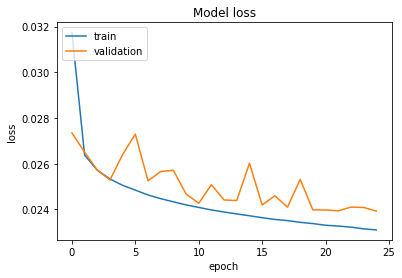

In [ ]:
################################################# plot tarining and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
################################## evaluate on test data
model.evaluate(x_test,y_test)

67/67 [==============================] - 10s 94ms/step - loss: 0.0242


0.02419406734406948

### Metrics of predicted enhanced signals

In [34]:
############################################## Make prediction of test data
pred = model.predict(x_test)

In [15]:
############################################### function to obtain metric scores
def get_metrics(y_true,y_pred):
  sdr=[]
  isr=[]
  sar=[]
  nb_pesq=[]
  pesq=[]
  sisdr=[]
  stoi=[]
  mosnet=[]
  srmr=[]
  rate=16000

  my_metrics_relative = speechmetrics.load('relative')
  my_metrics_absolute = speechmetrics.load('absolute')

  for i in range(len(y_true)):


   # print(i)
    try:
      clean = recoverSignalFromSpectrogram(y_true[i])
      enhanced = recoverSignalFromSpectrogram(y_pred[i])
      scipy.io.wavfile.write('clean.wav', rate, clean)
      scipy.io.wavfile.write('enhanced.wav', rate, enhanced)
      rate, ref = wavfile.read("/content/clean.wav")
      rate, deg = wavfile.read("/content/enhanced.wav")

      scores_relative = my_metrics_relative('/content/enhanced.wav', '/content/clean.wav')
      scores_absolute = my_metrics_absolute('/content/enhanced.wav', '/content/clean.wav')

      sdr.append(scores_relative.get('sdr').item())
      isr.append(scores_relative.get('isr').item())
      sar.append(scores_relative.get('sar').item())
      nb_pesq.append(scores_relative.get('nb_pesq').item())
      pesq.append(scores_relative.get('pesq').item())
      sisdr.append(scores_relative.get('sisdr').item())
      stoi.append(scores_relative.get('stoi').item())
      mosnet.append(scores_absolute.get('mosnet').item())
      srmr.append(scores_absolute.get('srmr').item())
  
    except:
      continue

  sdr_score = sum(sdr)/len(sdr)
  isr_score = sum(isr)/len(isr)
  sar_score = sum(sar)/len(sar)
  nb_pesq_score = sum(nb_pesq)/len(nb_pesq)
  pesq_score = sum(pesq)/len(pesq)
  sisdr_score = sum(sisdr)/len(sisdr)
  stoi_score = sum(stoi)/len(stoi)
  mosnet_score = sum(mosnet)/len(mosnet)
  srmr_score = sum(srmr)/len(srmr)

  print('sdr_score:',sdr_score)
  print('isr_score:',isr_score)
  print('sar_score:',sar_score)
  print('nb_pesq_score:',nb_pesq_score)
  print('pesq_score:',pesq_score)
  print('sisdr_score:',sisdr_score)
  print('stoi_score:',stoi_score)
  print('mosnet_score:',mosnet_score)
  print('srmr_score:',srmr_score)

  return 

In [33]:
####################################### obtain prediction metrics
get_metrics(y_test*255,pred*255)

Loaded  speechmetrics.relative.bsseval
Loaded  speechmetrics.relative.nb_pesq
Loaded  speechmetrics.relative.pesq
Loaded  speechmetrics.relative.sisdr
Loaded  speechmetrics.relative.stoi
Physical devices cannot be modified after being initialized
Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr
/usr/local/lib/python3.7/dist-packages/pystoi/stoi.py:69: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pypesq/init.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')
sdr_score: 3.7920791057051946
isr_score: 6.2206119215529965
sar_score: 7.123921816234163
nb_pesq_score: nan
pesq_score: 1.5445278559798385
sisdr_score: 4.22755590368421
stoi_score: 0.7326513637781072
mosnet_score: 2.9502086512891785
srmr_score: 6.844666198072306


### Metrics of noisy signals (not enhanced)

In [31]:
get_metrics(y_test*255,x_test*255)

Loaded  speechmetrics.relative.bsseval
Loaded  speechmetrics.relative.nb_pesq
Loaded  speechmetrics.relative.pesq
Loaded  speechmetrics.relative.sisdr
Loaded  speechmetrics.relative.stoi
Physical devices cannot be modified after being initialized
Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr
/usr/local/lib/python3.7/dist-packages/pystoi/stoi.py:69: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pypesq/init.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')
sdr_score: 0.4521941274633167
isr_score: 5.102811423307135
sar_score: 1.1854972062115168
nb_pesq_score: nan
pesq_score: 1.1813751373553242
sisdr_score: 0.6394261513675805
stoi_score: 0.4180824446201871
mosnet_score: 2.4671250700226052
srmr_score: 4.394589825204422


### Compare predicted, noisy and clean samples

In [ ]:
ran = random.randint(0,2118)

d_p = model.predict(x_test)[ran]*255
data_p = recoverSignalFromSpectrogram(d_p)
scipy.io.wavfile.write('p.wav', rate, data_p)

d_n = x_test[ran]*255
data_n = recoverSignalFromSpectrogram(d_n)
scipy.io.wavfile.write('n.wav', rate, data_n)

d_c = y_test[ran]*255
data_c = recoverSignalFromSpectrogram(d_c)
scipy.io.wavfile.write('c.wav', rate, data_c)

In [ ]:
ipd.Audio('p.wav')

In [ ]:
ipd.Audio('n.wav')

In [ ]:
ipd.Audio('c.wav')

Please note that in order to listen to the audio files the notebook needs to be downloaded.

In [ ]:
ran = random.randint(0,2118)

d_p = model.predict(x_test)[ran]*255
data_p = recoverSignalFromSpectrogram(d_p)
scipy.io.wavfile.write('p1.wav', rate, data_p)

d_n = x_test[ran]*255
data_n = recoverSignalFromSpectrogram(d_n)
scipy.io.wavfile.write('n1.wav', rate, data_n)

d_c = y_test[ran]*255
data_c = recoverSignalFromSpectrogram(d_c)
scipy.io.wavfile.write('c1.wav', rate, data_c)

In [ ]:
ipd.Audio('p1.wav')

In [ ]:
ipd.Audio('n1.wav')

In [ ]:
ipd.Audio('c1.wav')

Please note that in order to listen to the audio files the notebook needs to be downloaded.

In [ ]:
ran = random.randint(0,2118)

d_p = model.predict(x_test)[ran]*255
data_p = recoverSignalFromSpectrogram(d_p)
scipy.io.wavfile.write('p2.wav', rate, data_p)

d_n = x_test[ran]*255
data_n = recoverSignalFromSpectrogram(d_n)
scipy.io.wavfile.write('n2.wav', rate, data_n)

d_c = y_test[ran]*255
data_c = recoverSignalFromSpectrogram(d_c)
scipy.io.wavfile.write('c2.wav', rate, data_c)

In [ ]:
ipd.Audio('p2.wav')

In [ ]:
ipd.Audio('n2.wav')

In [ ]:
ipd.Audio('c2.wav')

Please note that in order to listen to the audio files the notebook needs to be downloaded.

### Visualizing waveforms

In [ ]:
def waveforms(p,n,c):
  wav_obj_p = wave.open(p, 'rb')
  sample_freq_p = wav_obj_p.getframerate()
  n_samples_p = wav_obj_p.getnframes()
  t_audio_p = n_samples_p/sample_freq_p
  n_channels_p = wav_obj_p.getnchannels()
  times_p = np.linspace(0, n_samples_p/sample_freq_p, num=n_samples_p)
  signal_wave_p = wav_obj_p.readframes(n_samples_p)
  signal_array_p = np.frombuffer(signal_wave_p, dtype=np.int16)

  wav_obj_c = wave.open(c, 'rb')
  sample_freq_c = wav_obj_c.getframerate()
  n_samples_c = wav_obj_c.getnframes()
  t_audio_c = n_samples_c/sample_freq_c
  n_channels_c = wav_obj_c.getnchannels()
  times_c = np.linspace(0, n_samples_c/sample_freq_c, num=n_samples_c)
  signal_wave_c = wav_obj_c.readframes(n_samples_c)
  signal_array_c = np.frombuffer(signal_wave_c, dtype=np.int16)

  wav_obj_n = wave.open(n, 'rb')
  sample_freq_n = wav_obj_n.getframerate()
  n_samples_n = wav_obj_n.getnframes()
  t_audio_n = n_samples_n/sample_freq_n
  n_channels_n = wav_obj_n.getnchannels()
  times_n = np.linspace(0, n_samples_n/sample_freq_n, num=n_samples_n)
  signal_wave_n = wav_obj_n.readframes(n_samples_n)
  signal_array_n = np.frombuffer(signal_wave_n, dtype=np.int16)

  plt.figure(figsize=(10, 2))
  plt.plot(times_p, signal_array_n)
  plt.title('Noisy')
  plt.ylabel('Signal Value')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_p)
  plt.show()

  plt.figure(figsize=(10, 2))
  plt.plot(times_c, signal_array_c)
  plt.title('Clean')
  plt.ylabel('Signal Value')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_c)
  plt.show()

  plt.figure(figsize=(10, 2))
  plt.plot(times_p, signal_array_p)
  plt.title('Predicted')
  plt.ylabel('Signal Value')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_p)
  plt.show()

  plt.figure(figsize=(10, 2))
  plt.specgram(signal_array_n, Fs=sample_freq_n, vmin=-20, vmax=50)
  plt.title('Noisy')
  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_n)
  plt.colorbar()
  plt.show()

  plt.figure(figsize=(10, 2))
  plt.specgram(signal_array_c, Fs=sample_freq_c, vmin=-20, vmax=50)
  plt.title('Clean')
  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_c)
  plt.colorbar()
  plt.show()

  plt.figure(figsize=(10, 2))
  plt.specgram(signal_array_p, Fs=sample_freq_p, vmin=-20, vmax=50)
  plt.title('Predicted')
  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.xlim(0, t_audio_p)
  plt.colorbar()
  plt.show()




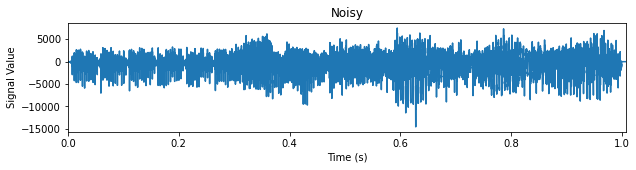

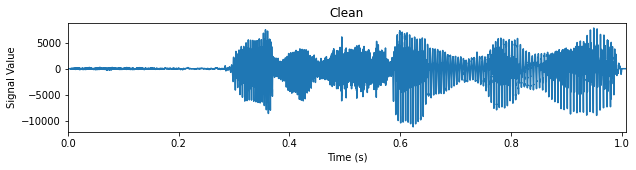

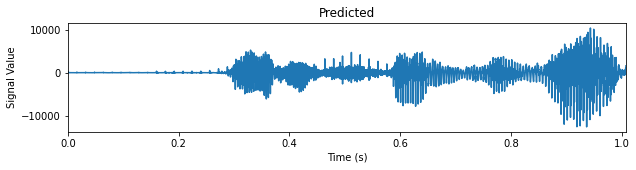

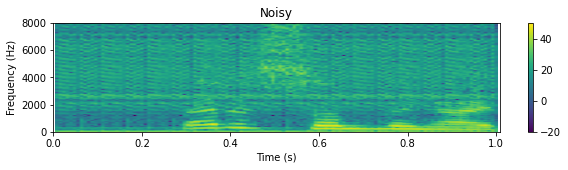

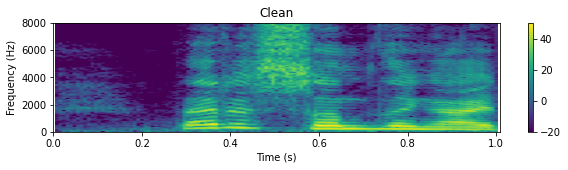

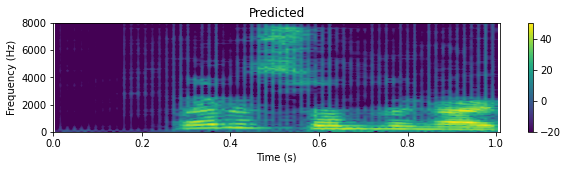

In [ ]:
waveforms('/content/p.wav','/content/n.wav','/content/c.wav')

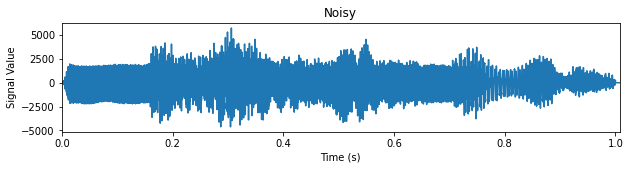

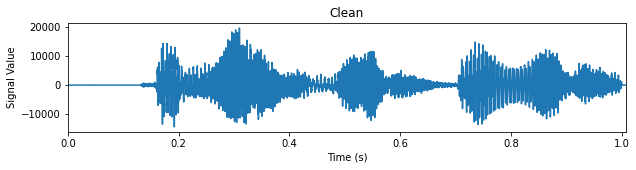

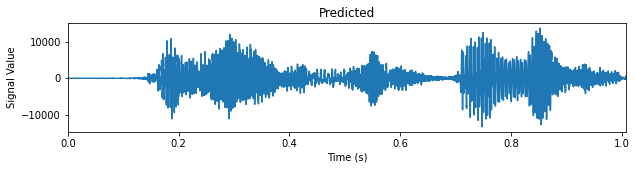

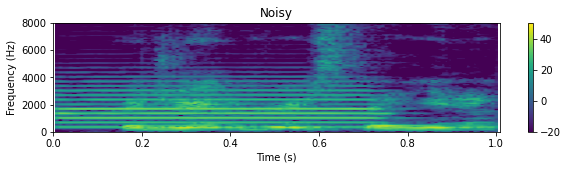

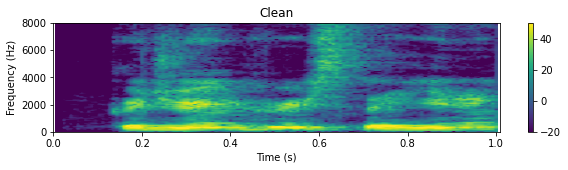

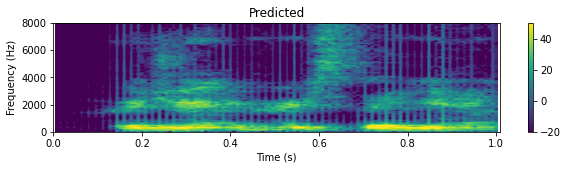

In [ ]:
waveforms('/content/p1.wav','/content/n1.wav','/content/c1.wav')

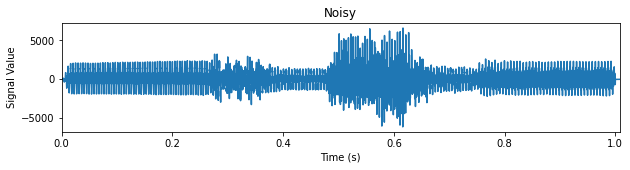

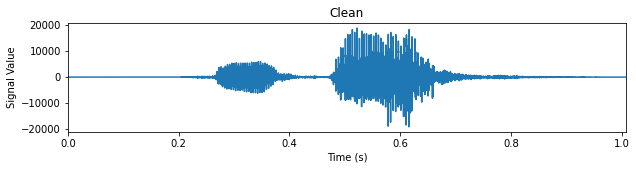

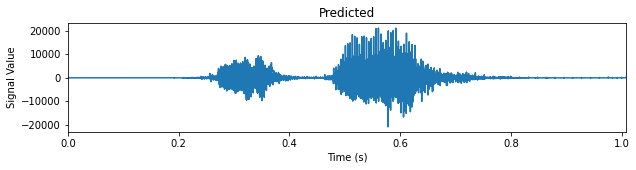

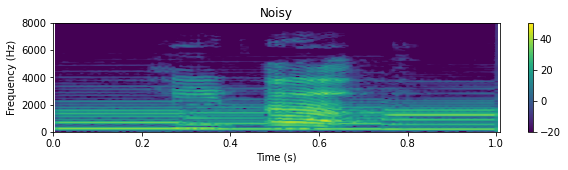

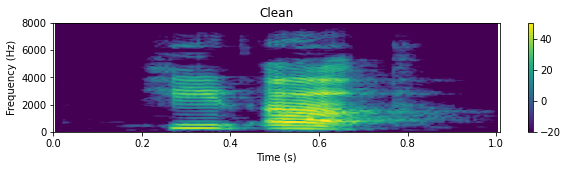

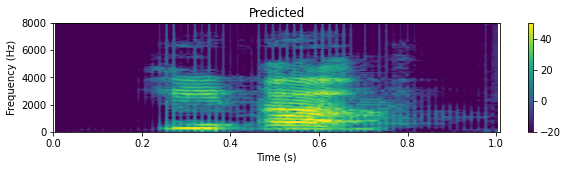

In [ ]:
waveforms('/content/p2.wav','/content/n2.wav','/content/c2.wav')

# Conditional GANs


### Training Data

In [5]:
batch_size=16
dataset = tf.data.Dataset.from_tensor_slices((y_train, x_train)).batch(batch_size)
tf.data.experimental.save(dataset, "/content/drive/MyDrive/DATA7")

In [6]:
dataset = tf.data.experimental.load("/content/drive/MyDrive/DATA7")

### Construct Model

In [12]:
# Create the discriminator.
generator = keras.Sequential(
    [
        # encoder
        keras.layers.InputLayer((257,62,3)),                     
        keras.layers.Conv2D(8, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2D(16, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2D(32, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2D(64, kernel_size=3, strides=2),
        keras.layers.PReLU(),
     
        # decoder
        keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2),
        keras.layers.PReLU(),
        keras.layers.Conv2DTranspose(3, kernel_size=16, strides=1),
        keras.layers.PReLU(),
        keras.layers.Cropping2D(((13,0),(0,0)))  
     
    ],
    name="generator"
    )
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 30, 8)        224       
                                                                 
 p_re_lu_9 (PReLU)           (None, 128, 30, 8)        30720     
                                                                 
 conv2d_10 (Conv2D)          (None, 63, 14, 16)        1168      
                                                                 
 p_re_lu_10 (PReLU)          (None, 63, 14, 16)        14112     
                                                                 
 conv2d_11 (Conv2D)          (None, 31, 6, 32)         4640      
                                                                 
 p_re_lu_11 (PReLU)          (None, 31, 6, 32)         5952      
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 2, 64)         18

In [13]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((257,62,6)),                     
        keras.layers.Conv2D(8, kernel_size=3, strides=2),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(16, kernel_size=3, strides=2),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(32, kernel_size=3, strides=2),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(64, kernel_size=3, strides=2),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(), 
        keras.layers.Conv2D(1, kernel_size=1, strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(1),
        
    ],
    name="discriminator"
    )
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 30, 8)        440       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 30, 8)       32        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 30, 8)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 63, 14, 16)        1168      
                                                                 
 batch_normalization_5 (Batc  (None, 63, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 63, 14, 16)      

In [14]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        y_train, x_train = data

        batch_size = tf.shape(x_train)[0]
        noise= x_train
        generated_images = self.generator(noise)
        real_images = y_train

        real_images= tf.cast(real_images, dtype = tf.float32)
        noise= tf.cast(noise, dtype = tf.float32)

        fake_image_and_noise = tf.concat([generated_images, noise], -1)
        real_image_and_noise = tf.concat([real_images, noise], -1)
        
        
        combined_images = tf.concat(
            [fake_image_and_noise, real_image_and_noise], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Assemble labels that say "all real images".
        #noise= x_train
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            fake_image_and_labels = tf.concat([fake_images, noise], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [15]:
gan = ConditionalGAN(
    discriminator=discriminator, generator=generator
)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

### Fit Model

In [23]:
mse=tf.keras.losses.MeanSquaredError()
cross= tf.keras.losses.BinaryCrossentropy(from_logits=True)

val_mse=[]
val_cross=[]
train_loss_G=[]
train_loss_D=[]
for e in range(1,101):
  print("Epoch " +str(e)+ (":"))
  history = gan.fit(dataset, epochs=1)
  train_loss_D.append(history.history["d_loss"])
  train_loss_G.append(history.history["g_loss"])
  prediction = gan.generator(x_val)
  true = y_val
  val_mse.append(mse(true,prediction).numpy())
  val_cross.append(cross(true,prediction).numpy())
  print("val loss mse: " +str(mse(true,prediction).numpy()))
  print("val loss Binary Crossentropy: " +str(cross(true,prediction).numpy()))
  if val_mse[e] < 0.045:
    break 

Epoch 1:
1125/1125 [==============================] - 35s 28ms/step - g_loss: 21.4163 - d_loss: 0.8573
val loss mse: 0.0796302
val loss Binary Crossentropy: 0.69931823
Epoch 2:
1125/1125 [==============================] - 34s 29ms/step - g_loss: 7.3894 - d_loss: 0.2184
val loss mse: 0.11297544
val loss Binary Crossentropy: 0.7011951
Epoch 3:
1125/1125 [==============================] - 36s 31ms/step - g_loss: 10.5741 - d_loss: 0.3720
val loss mse: 0.06919112
val loss Binary Crossentropy: 0.715618
Epoch 4:
1125/1125 [==============================] - 36s 31ms/step - g_loss: 2.9613 - d_loss: 0.1993
val loss mse: 0.05919141
val loss Binary Crossentropy: 0.71087414
Epoch 5:
1125/1125 [==============================] - 36s 31ms/step - g_loss: 4.5278 - d_loss: 0.1818
val loss mse: 0.04790201
val loss Binary Crossentropy: 0.70676696
Epoch 6:
1125/1125 [==============================] - 33s 28ms/step - g_loss: 4.7574 - d_loss: 0.3571
val loss mse: 0.0559967
val loss Binary Crossentropy: 0.7108

### Evaluate Model

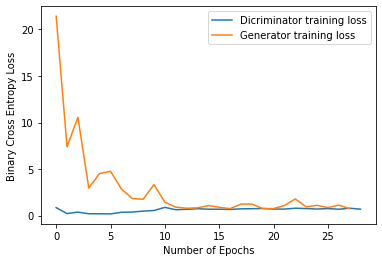

In [27]:
####################################################### Plot discriminator and generator training loss
plt.plot(train_loss_D, label='Dicriminator training loss')
plt.plot(train_loss_G, label='Generator training loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend();

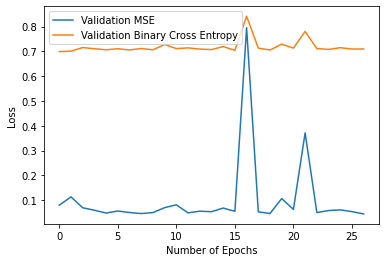

In [30]:
############################################### Plot Validation MSE and Validation Binary Cross Entropy
plt.plot(val_mse, label='Validation MSE')
plt.plot(val_cross, label='Validation Binary Cross Entropy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

### Metrics of predicted, enhanced signals

In [24]:
y_pred=gan.generator(x_test)
y_true=y_test
get_metrics(y_true*255,y_pred*255)

Loaded  speechmetrics.relative.bsseval
Loaded  speechmetrics.relative.nb_pesq
Loaded  speechmetrics.relative.pesq
Loaded  speechmetrics.relative.sisdr
Loaded  speechmetrics.relative.stoi
Physical devices cannot be modified after being initialized
Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr
/usr/local/lib/python3.7/dist-packages/pystoi/stoi.py:69: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pypesq/init.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')
sdr_score: 1.45771872142546
isr_score: 5.172998171389487
sar_score: 4.386247561263102
nb_pesq_score: nan
pesq_score: 1.4172415428511255
sisdr_score: 1.784304520664444
stoi_score: 0.65700148954390354
mosnet_score: 2.68008325796684
srmr_score: 6.2216383144782899


# Reverse Model

### Construct Model

In [ ]:
###################################################### 
model_rev = Sequential()

# encoder
model_rev.add(Input(shape=(257,62,3)))
model_rev.add(ZeroPadding2D(((3,0),(0,2))))
model_rev.add(Conv2D(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model_rev.add(BatchNormalization())
model_rev.add(Conv2D(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model_rev.add(BatchNormalization())



# decoder
model_rev.add(Conv2DTranspose(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model_rev.add(BatchNormalization())
model_rev.add(Conv2DTranspose(256, kernel_size=5,padding='same',strides = (2,2),activation='relu'))
model_rev.add(BatchNormalization())
model_rev.add(Conv2DTranspose(3, kernel_size=1,padding='same',activation='sigmoid'))
model_rev.add(Cropping2D(((3,0),(0,2))))

model_rev.summary()


opt = Adam(learning_rate=0.005)
model_rev.compile(optimizer=opt, loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 260, 64, 3)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 130, 32, 256)      19456     
                                                                 
 batch_normalization (BatchN  (None, 130, 32, 256)     1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 16, 256)       1638656   
                                                                 
 batch_normalization_1 (Batc  (None, 65, 16, 256)      1024      
 hNormalization)                                                 
                                                        

### Fit Model

In [ ]:
history_rev = model_rev.fit(y_train, x_train,
                epochs=20,
                batch_size=16,validation_data=(y_val, x_val),shuffle=True) 

Epoch 1/20
1125/1125 [==============================] - 228s 191ms/step - loss: 0.0346 - val_loss: 0.0330
Epoch 2/20
1125/1125 [==============================] - 213s 189ms/step - loss: 0.0320 - val_loss: 0.0322
Epoch 3/20
1125/1125 [==============================] - 212s 188ms/step - loss: 0.0317 - val_loss: 0.0319
Epoch 4/20
1125/1125 [==============================] - 211s 187ms/step - loss: 0.0316 - val_loss: 0.0319
Epoch 5/20
1125/1125 [==============================] - 211s 188ms/step - loss: 0.0315 - val_loss: 0.0313
Epoch 6/20
1125/1125 [==============================] - 211s 187ms/step - loss: 0.0314 - val_loss: 0.0312
Epoch 7/20
1125/1125 [==============================] - 211s 187ms/step - loss: 0.0313 - val_loss: 0.0315
Epoch 8/20
1125/1125 [==============================] - 211s 187ms/step - loss: 0.0313 - val_loss: 0.0314
Epoch 9/20
1125/1125 [==============================] - 211s 187ms/step - loss: 0.0312 - val_loss: 0.0312
Epoch 10/20
1125/1125 [=======================

In [ ]:
model_rev.save('/content/drive/MyDrive/model_auto_rev')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_auto_rev/assets


In [ ]:
model_rev = tf.keras.models.load_model('/content/drive/MyDrive/model_auto_rev')

### Evaluate Reverse Model

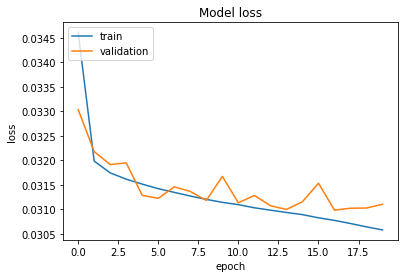

In [ ]:
################################################# plot loss and accuracy
plt.plot(history_rev.history['loss'])
plt.plot(history_rev.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_rev.evaluate(y_test,x_test)

67/67 [==============================] - 10s 93ms/step - loss: 0.0314


0.03141288459300995

### Compare predicted, noisy and clean samples

In [ ]:
pred_rev = model_rev.predict(y_test)

In [ ]:
ran = random.randint(0,2118)

d_p = model_rev.predict(y_test)[ran]*255
data_p = recoverSignalFromSpectrogram(d_p)
scipy.io.wavfile.write('p_rev.wav', rate, data_p)

d_n = x_test[ran]*255
data_n = recoverSignalFromSpectrogram(d_n)
scipy.io.wavfile.write('n_rev.wav', rate, data_n)

d_c = y_test[ran]*255
data_c = recoverSignalFromSpectrogram(d_c)
scipy.io.wavfile.write('c_rev.wav', rate, data_c)

In [ ]:
ipd.Audio('p_rev.wav')

In [ ]:
ipd.Audio('n_rev.wav')

In [ ]:
ipd.Audio('c_rev.wav')

Please note that in order to listen to the audio files the notebook needs to be downloaded.

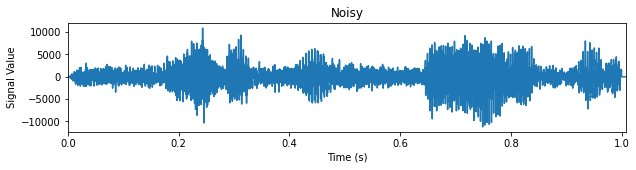

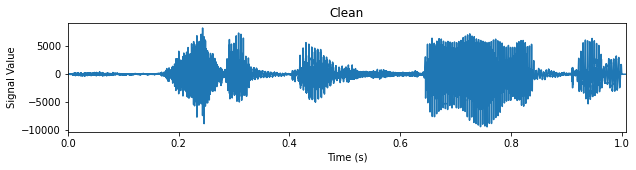

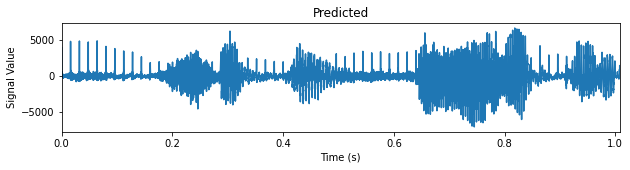

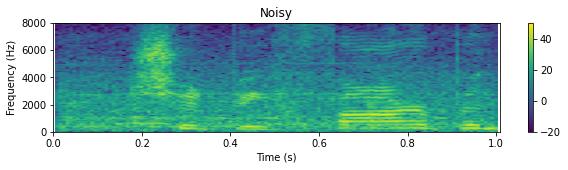

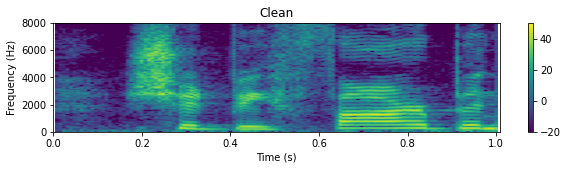

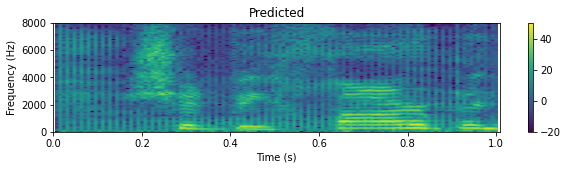

In [ ]:
waveforms('/content/p_rev.wav','/content/n_rev.wav','/content/c_rev.wav')